<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/dense_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyDrive
!mkdir work_dir

# DEFINE

In [2]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [3]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import PIL
import cv2
import re

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm
from scipy.stats import shapiro

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# DOWNLOAD DATA

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Download clear_train.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/clear_train.csv') # куда сохраняем файл в вирутальной машине колаба

# Download clear_test.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-0yG59TcpJoDSeOclid1z-nc1Fh3yud2"})
downloaded.GetContentFile(DATA_PATH+'/clear_test.csv')

# Download sample_submission from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1Edwuioev6uEyeXuCQuloPNQ70V5-3HZG"})
downloaded.GetContentFile(DATA_PATH+'/sample_submission.csv')

In [12]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')

# PREPARING

In [13]:
df = pd.concat([train, test])

(array([  73.,  310., 1460., 2195., 2075.,  600., 1091.,  449.,    0.,
         100.]),
 array([14175.44005965, 14175.82369518, 14176.2073307 , 14176.59096623,
        14176.97460175, 14177.35823728, 14177.7418728 , 14178.12550832,
        14178.50914385, 14178.89277937, 14179.2764149 ]),
 <a list of 10 Patch objects>)

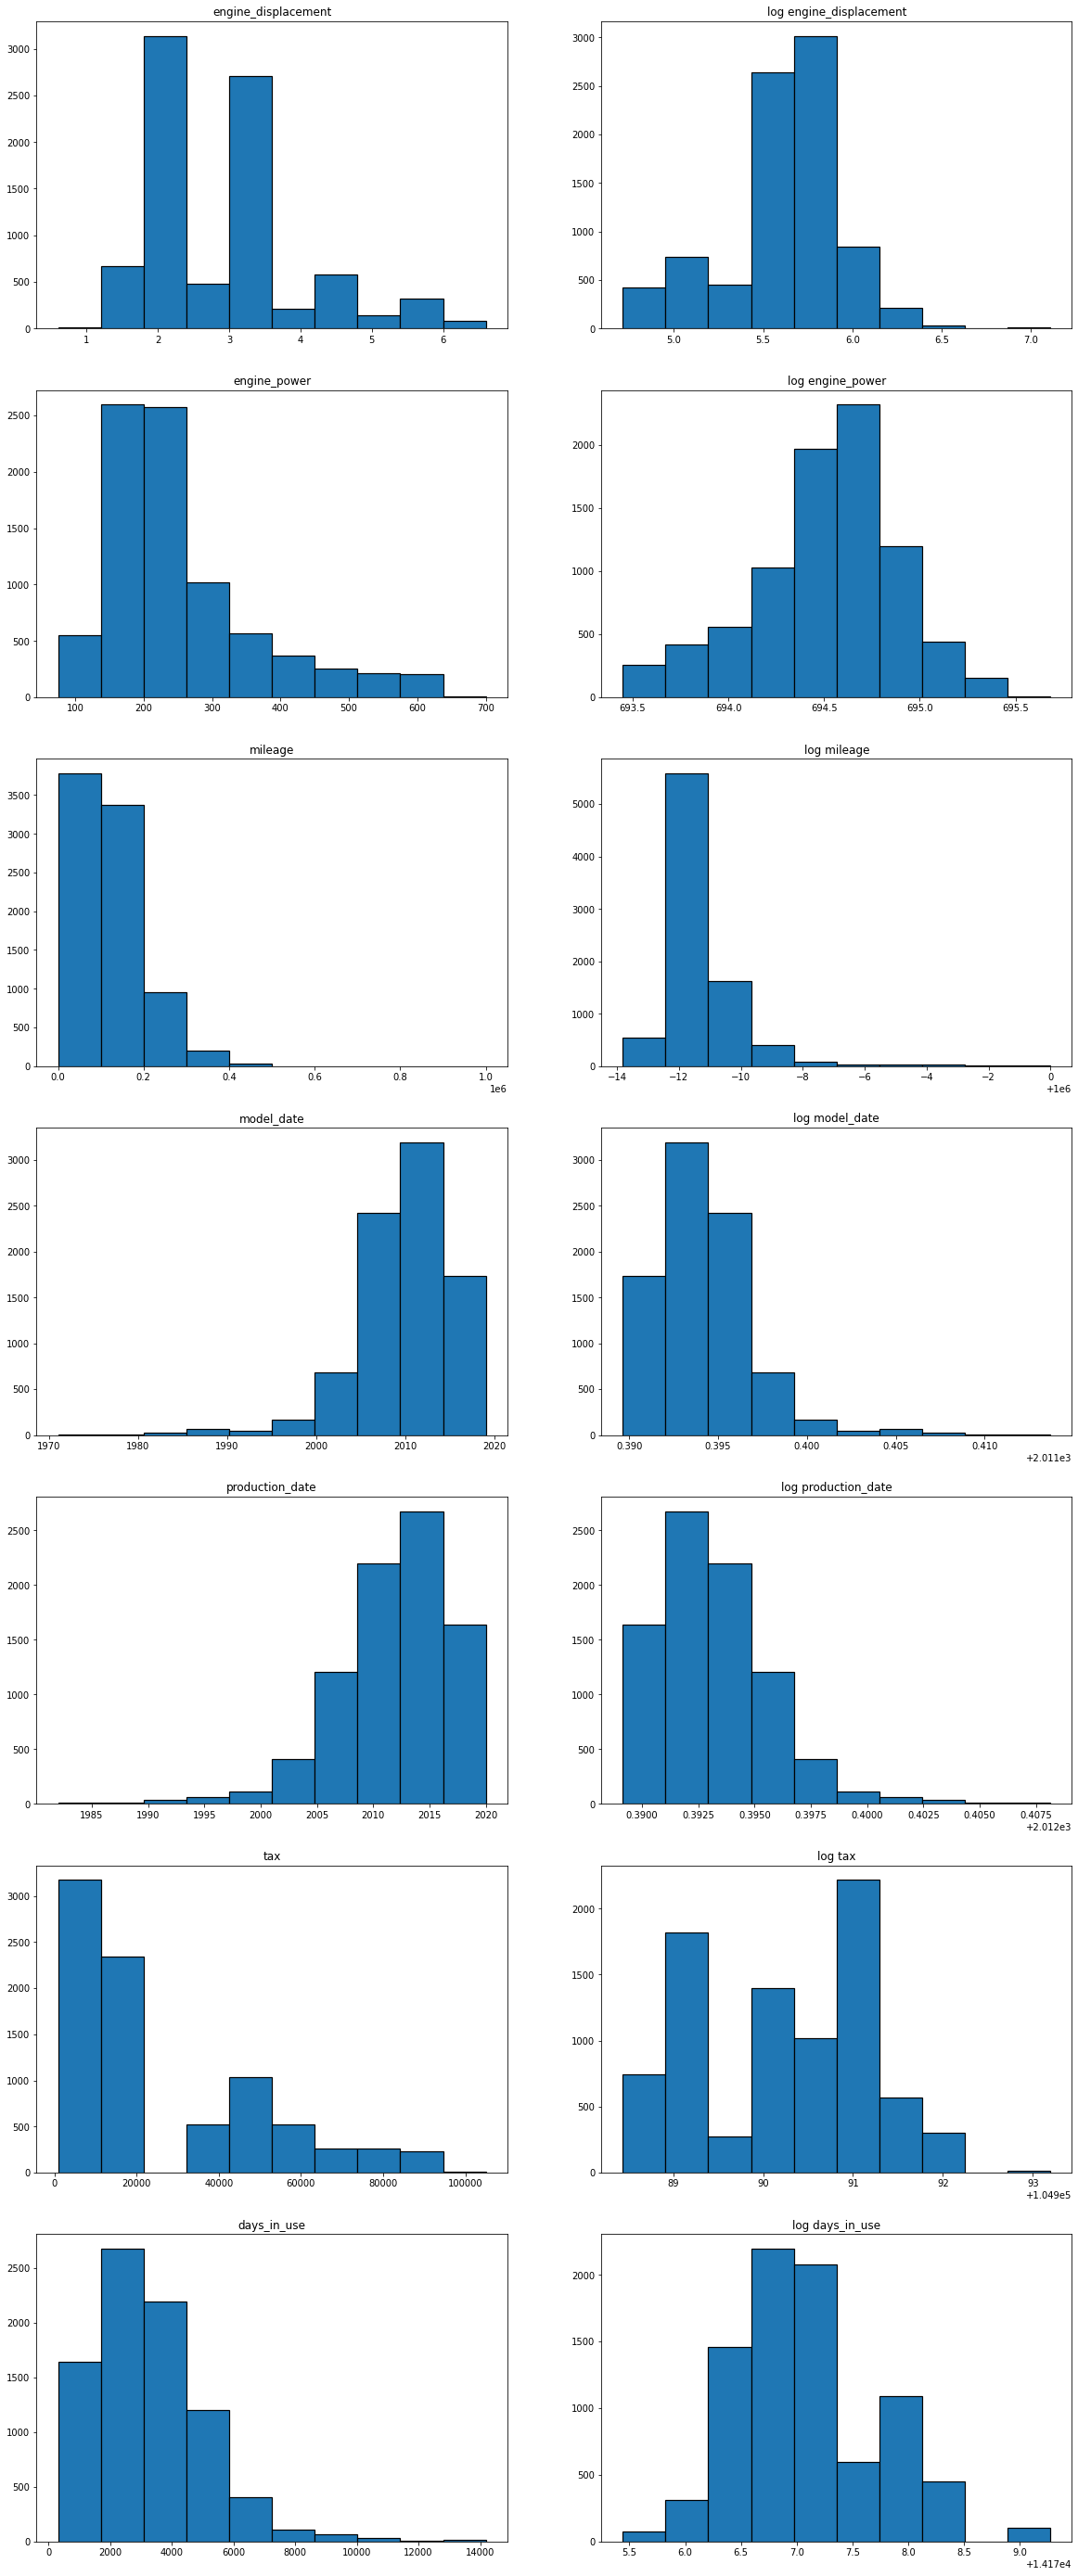

In [14]:
fig, ax = plt.subplots(7,2, figsize=(20,50))

# ####################### engine_displacement ############################
ax[0,0].set_title('engine_displacement')
ax[0,0].hist(df['engine_displacement'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[0,1].set_title('log engine_displacement')
ax[0,1].hist(df['engine_displacement'].max() - np.log(df['engine_displacement']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### engine_power ############################
ax[1,0].set_title('engine_power')
ax[1,0].hist(df['engine_power'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[1,1].set_title('log engine_power')
ax[1,1].hist(df['engine_power'].max() - np.log(df['engine_power']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### mileage ############################
ax[2,0].set_title('mileage')
ax[2,0].hist(df['mileage'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[2,1].set_title('log mileage')
ax[2,1].hist(df['mileage'].max() - np.log(df['mileage']), bins=10, edgecolor='black' ,linewidth=1.2)


# ####################### model_date ############################
ax[3,0].set_title('model_date')
ax[3,0].hist(df['model_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[3,1].set_title('log model_date')
ax[3,1].hist(df['model_date'].max() - np.log(df['model_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### production_date ############################
ax[4,0].set_title('production_date')
ax[4,0].hist(df['production_date'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[4,1].set_title('log production_date')
ax[4,1].hist(df['production_date'].max() - np.log(df['production_date']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### tax ############################
ax[5,0].set_title('tax')
ax[5,0].hist(df['tax'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[5,1].set_title('log tax')
ax[5,1].hist(df['tax'].max() - np.log(df['tax']), bins=10, edgecolor='black' ,linewidth=1.2)

# ####################### days_in_use ############################
ax[6,0].set_title('days_in_use')
ax[6,0].hist(df['days_in_use'], bins=10, edgecolor='black' ,linewidth=1.2)
ax[6,1].set_title('log days_in_use')
ax[6,1].hist(df['days_in_use'].max() - np.log(df['days_in_use']), bins=10, edgecolor='black' ,linewidth=1.2)

In [15]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [16]:
# ##################### Логорифмируем ######################
df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
df.engine_power = df.engine_power.max() - np.log(df.engine_power)
# df.mileage = df.mileage.max() - np.log(df.mileage)
# df.model_date = df.model_date.max() - np.log(df.model_date)
# df.production_date = df.production_date.max() - np.log(df.production_date)
# df.num_of_doors = np.log(df.num_of_doors)
# df.tax = np.log(df.tax)
# df.days_in_use = df.days_in_use.max() - np.log(df.days_in_use)

Модель показывает лучше результат, если признак **num_of_doors** сделать категориальным.

Если взять логорифм перед нормализацией от всех признаков, кроме **mileage**, то модель показывает лучший результат

In [17]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [18]:
df = data_prep(df)
df.shape

(8353, 545)

# SPLIT

In [67]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

В результате многих опытов выяснил, что наилучший результат модель показывает, когда на валидационную выборку выделено наименьшее количество данных. Если я правильно понимаю это связано с тем, что я выделаю больше данных для обучения. Отсюда можно сделать логичный вывод, что имея в целом больше данных модель будет выдавать результат лучше.

# MODEL

In [68]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [69]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ######################### Create simple neural network #############################
  model = Sequential()
  model.add(L.Dense(1090, input_dim=X_train.shape[1], activation="relu", name='dense_1090'))
  model.add(L.Dropout(0.85))
  model.add(L.Dense(545, activation="relu", name='dense_545'))
  model.add(L.Dense(1, activation="linear", name='output_dense_1'))

  display(model.summary())

  # ######################### Optimizer ##############################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adam(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ######################## Checkpoints #############################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor='val_MAPE', verbose=1  , mode='min', save_best_only=True)
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1
                   )
  
  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_1.hdf5')

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.legend()
  plt.grid()
  plt.show()

  test_predict_nn1 = model.predict(X_test)
  print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

  return model, checkpoint, earlystop, callbacks_list, history

Опытным путем установил, что лучший результат модель показывает, когда мы используем **Adamax optimizer** с **learning rate 0.1**

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1090 (Dense)           (None, 1090)              591870    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1090)              0         
_________________________________________________________________
dense_545 (Dense)            (None, 545)               594595    
_________________________________________________________________
output_dense_1 (Dense)       (None, 1)                 546       
Total params: 1,187,011
Trainable params: 1,187,011
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/1000
12/12 [==============================] - ETA: 0s - loss: 89.9652 - MAPE: 89.9652  
Epoch 00001: val_MAPE improved from inf to 56.48202, saving model to /content/work_dir/best_model.hdf5
12/12 [==============================] - 0s 24ms/step - loss: 89.9652 - MAPE: 89.9652 - val_loss: 56.4820 - val_MAPE: 56.4820
Epoch 2/1000
11/12 [==========================>...] - ETA: 0s - loss: 55.3295 - MAPE: 55.3295
Epoch 00002: val_MAPE improved from 56.48202 to 47.03088, saving model to /content/work_dir/best_model.hdf5
12/12 [==============================] - 0s 32ms/step - loss: 54.8726 - MAPE: 54.8726 - val_loss: 47.0309 - val_MAPE: 47.0309
Epoch 3/1000
11/12 [==========================>...] - ETA: 0s - loss: 47.0516 - MAPE: 47.0516
Epoch 00003: val_MAPE improved from 47.03088 to 42.36259, saving model to /content/work_dir/best_model.hdf5
12/12 [==============================] - 0s 32ms/step - loss: 46.6384 - MAPE: 46.6384 - val_loss: 42.3626 - val_MAPE: 42.3626
Epoch 4/1000
12/12 

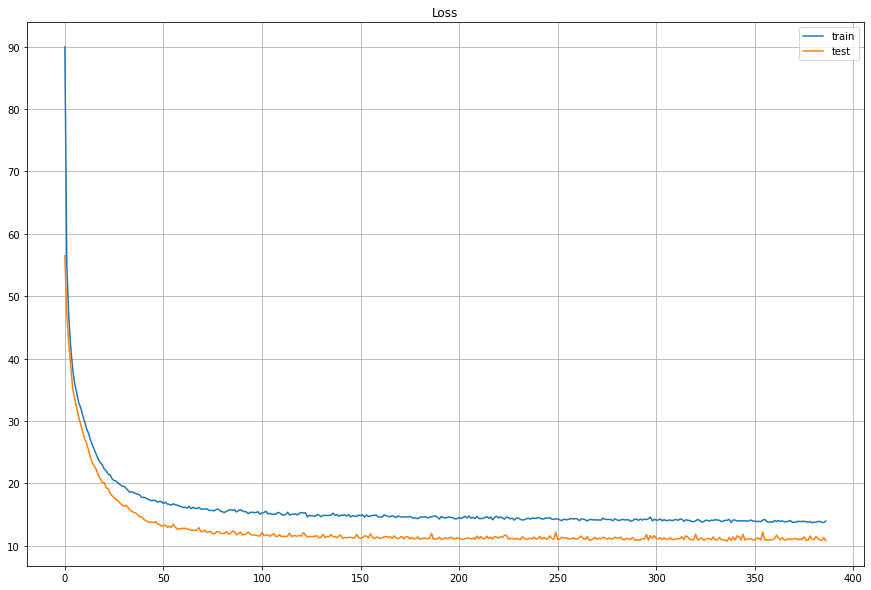

TEST mape: 10.75%


In [70]:
model, checkpoint, earlystop, callbacks_list, history = build_model(LR=0.1, EPOCHS=1000, OPTIMIZER_TYPE='Adamax')

По графику получаеться, на валидационной выборке результат лучше, чем на тренировочной. Поискал в интеренете информацию по этому поводу. Кто-то говорит, что это overfitting (переобучение). Кто-то говорит, что это может быть связанно с тем, что в валидационную выборку попадают более простые данные, на которых лечге удается предсказать таргет. На данный момент, при таком графике результат на кагле получаеться самый высокий.

# PREDICT

In [72]:
predict_submission = model.predict(test)

sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+'/sub_nn.csv', index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,5.159345e+05
1,1096405886,2.549579e+06
2,1100195294,6.613601e+05
3,1099827282,5.006911e+05
4,1100076198,2.784018e+06
5,1090159352,3.271747e+06
6,1098987386,1.673890e+06
7,1098639040,1.574048e+06
8,1099933039,1.118345e+06
9,1099565572,5.146855e+05
